In [2]:
#importing libraries
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import random
from scipy.stats import truncnorm
import scipy.stats as stats
import math
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#### Update rules for change in opinion and in weight of relationship

_Original update rules_ :

1. Change in opinion: $\Delta o_i = \alpha w_{ij}(o_j-o_i)$

2. Change in weight: $\Delta w_{ij} = \beta w_{ij} (1-w_{ij})(1-\gamma |o_i - o_j|)$

_Proposed modifications_ :

1. Change in opinion: $\Delta o_i =  \frac{1}{2}p_jw_{ij}(o_j-o_i)$
    
2. Change in weight: $\Delta w_{ij} = \beta w_{ij} (1-w_{ij})(1-\gamma (2-p_j-p_i)|o_i - o_j|)$

### Theoretical Analysis

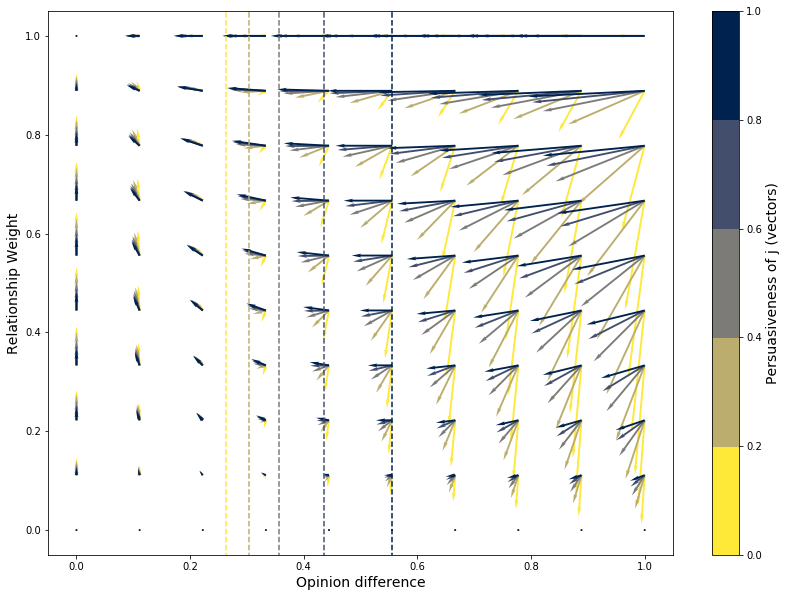

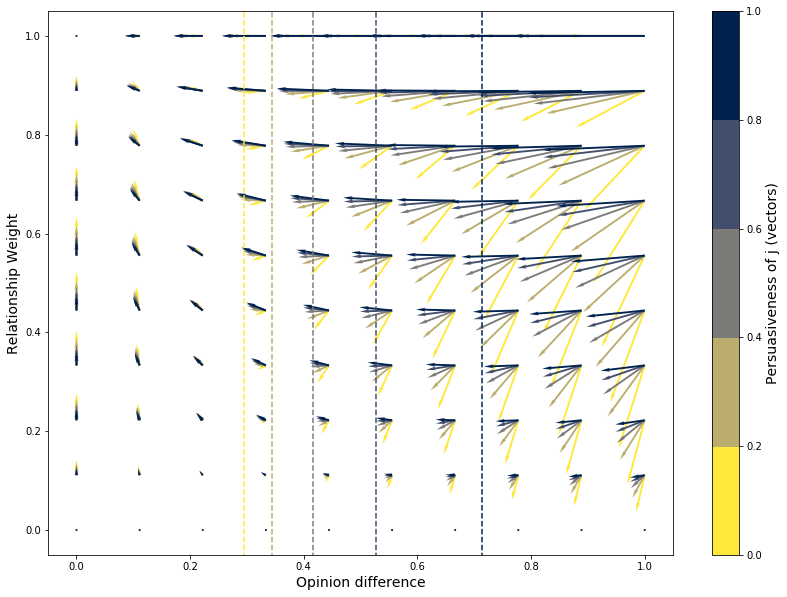

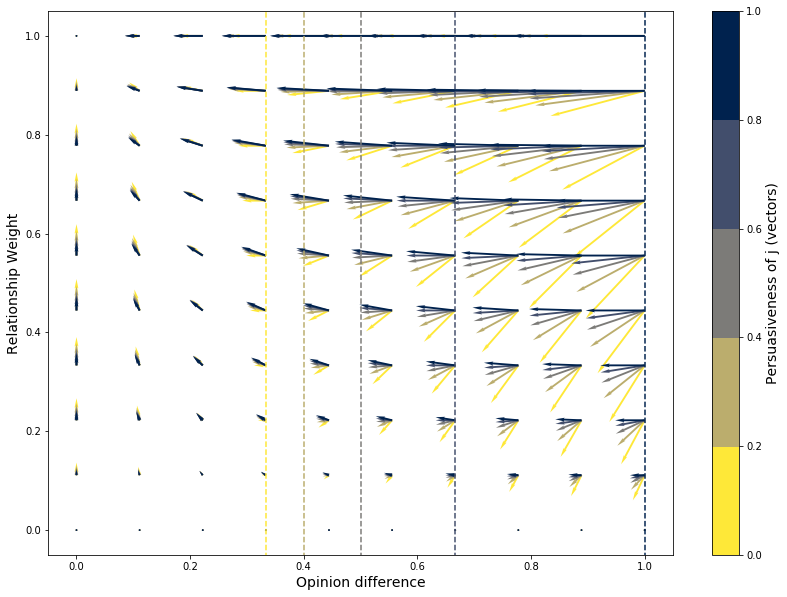

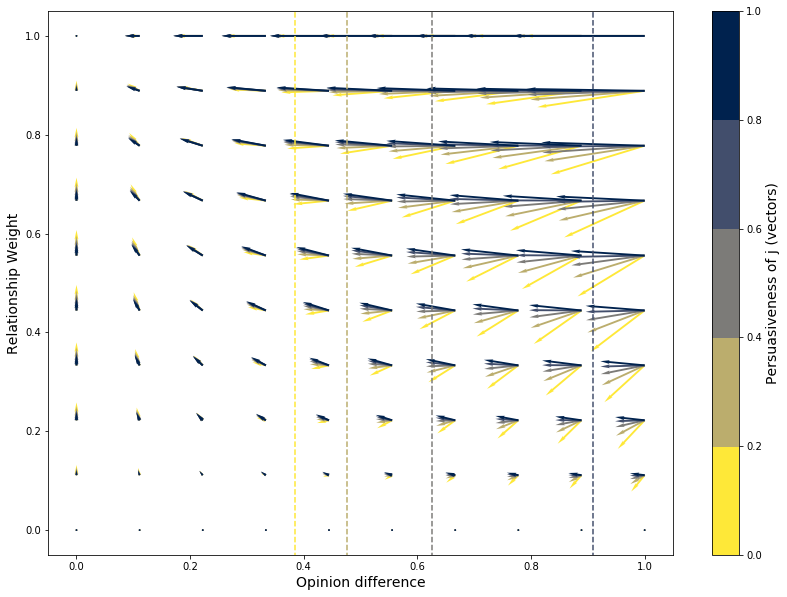

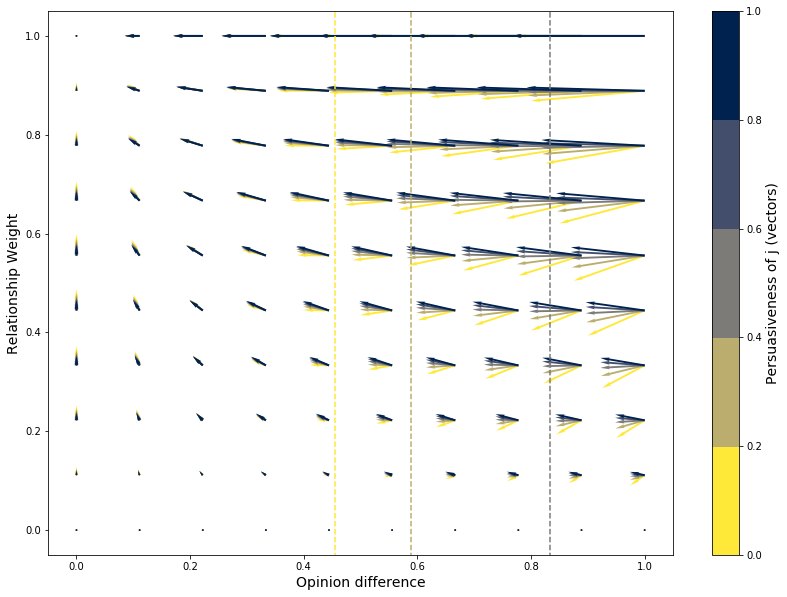

In [3]:
def compute_vector(x,y,p_i,p_j,beta=0.3,gamma=2):
    '''
    This function takes the current opinion difference (x) and relationship weight (y) between
    two nodes, the corresponding persuasiveness values for each node, a beta parameter,
    and a gamma parameter as input and 
    returns the change in difference of opinions and in weight of relationship according
    to the rules for the proposed modifications.
    '''
    
    d = -(1/2)*y*x*(p_i+p_j) #difference in difference of opinion 
    w = beta*y*(1-y)*(1-gamma*(2-p_j-p_i)*abs(x)) #difference in weight
    
    return d,w

n_i = 5 #range of p_i
n_j = 5 #range of p_j
x = np.linspace(0,1,10) #opinion linspace
y = np.linspace(0,1,10) #weight  linspace
X,Y = np.meshgrid(x,y)  #meshgrid for vector field plot
persuasiveness_values_i = np.linspace(0.1,0.9,n_i) #p_i linspace
persuasiveness_values_j = np.linspace(0,1,n_j)     #p_j linspace


beta = 0.3
gamma = 2

#colormmaps
cmap1 = cm.get_cmap('cividis_r',n_j)

#generating vector field plots
for p_i in persuasiveness_values_i:
    plt.figure(figsize=(14,10))
    shade = 0
    for p_j in persuasiveness_values_j:
        p_i = round(p_i,2)
        p_j = round(p_j,2)
        U,V = compute_vector(X,Y,p_i,p_j,beta,gamma)
        plt.quiver(X,Y,U,V,color = cmap1(shade/n_j),width=0.003, headwidth=2)
        d = 1/(4-2*(p_i+p_j))
        plt.plot([d,d],[-0.2,1.2], color = cmap1(shade/n_j), linestyle = 'dashed')
        shade+=1
    plt.xlabel('Opinion difference',fontsize =14)
    plt.ylabel('Relationship Weight',fontsize =14)
    plt.ylim([-0.05,1.05])
    plt.xlim([-0.05,1.05])
    cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap1))
    cbar.set_label('Persuasiveness of j (vectors)',fontsize =14)
    plt.show()

### Original Simulation Class 

In [4]:
class OriginalSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=100, alpha=0.03, beta=0.3, gamma=4):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 100.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.randomcreations = 0

    def initialize(self, graph = None):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        if not graph:
            self.graph = nx.watts_strogatz_graph(self.network_size, 5, 0.5)
            for edge in self.graph.edges:
                self.graph.edges[edge]['weight'] = 0.5
            for node in self.graph.nodes:
                self.graph.nodes[node]['opinion'] = random.randint(0, 1)
        else:
            self.graph = graph
        
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1, cmap=plt.cm.get_cmap('plasma'))
        plt.title('Original\nStep: ' + str(self.step), fontsize=18)

    def update(self):
        if random.uniform(0, 1) < 0.01:
            self.randomcreations+=1
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

In [7]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

class NewSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on proposed modifications.
    '''

    def __init__(self, network_size=100, alpha=0.03, beta=0.3, gamma=2, q = 0.9, l=0.75):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 100.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: .
              
            q (float) The probability of creating a new connection based on the
              introducing friends procedure.
              
            l (float) The upper bound for the weight of new relationships created
              through the introducing friends procedure.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.q = q
        self.l = l

    def initialize(self, graph = None):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        Persuasiveness is also randomly assigned, sampled from a truncated
        normal distribution.
        '''
        if not graph:
            self.graph = nx.watts_strogatz_graph(self.network_size, 5, 0.5)
            for edge in self.graph.edges:
                self.graph.edges[edge]['weight'] = 0.5
            for node in self.graph.nodes:
                self.graph.nodes[node]['opinion'] = random.randint(0, 1)
                self.graph.nodes[node]['persuasiveness'] = SamplerTruncNorm.rvs() #taking sample from truncated normal distribution
        
        else:
            self.graph = graph
            
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1, cmap = plt.cm.get_cmap('plasma'))
        plt.title('Modified (q = {})\nStep: '.format(self.q) + str(self.step), fontsize=18)

    def update(self):
        if random.uniform(0, 1) < 0.01:
            nodes = list(self.graph.nodes)
            created_new = False
            if random.random() < self.q:
                # Create a new edge using the introducer and introduced procedure with probability q
                count = 0 #counter to set limit on the while loop
                while True:
                    count+=1
                    introducing_pair = random.choice(list(self.graph.edges)) #randomly choosing an edge
                    A = introducing_pair[0] #A
                    B = introducing_pair[1] #B
                    A_friends = set(self.graph.neighbors(A)) #A's friends
                    B_friends = set(self.graph.neighbors(B)) #B's friends
                    potential_friends = A_friends-B_friends-set([B]) #friends of A not friends of B
                    if potential_friends or count>2000: #if there are potential friends or if we've gone past the limit of 2000
                        break
                        
                #if there were potential friends to introduce
                if potential_friends:
                    C = random.choice(list(A_friends)) #randomly choosing C
                    w_AC = self.graph.edges[A,C]['weight'] #weight of A and C
                    w_AB = self.graph.edges[A,B]['weight'] #weight of A and B
                    self.graph.add_edge(B,C, weight = self.l*w_AB*w_AC) #introducing B and C and assigning weight according to formula
                    created_new = True #boolean that tells we have already created a new connection
                else:
                    print('Did not create new edges') #check whether new edge connection was not found with this procedure
                
            if not created_new: 
                # Create a new edge using original random procedure with probability 1-q or when we could not create new connection with new procedure
                while True:
                    new_edge = random.sample(nodes, 2)
                    if new_edge not in self.graph.edges:
                        break
                self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
                
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            persuas = [self.graph.nodes[n]['persuasiveness'] for n in edge] #obtaining p_i and p_j
            for i in [0, 1]:
            #modified to satisfy proposed equation
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * persuas[1-i] * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * (2-sum(persuas)) * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

In [8]:
#plotting nice histogram with color map function
def plot_hist(data):
    Y,X = np.histogram(data, 25)
    x_span = 1
    cm = plt.cm.get_cmap('plasma')
    C = [cm((x/x_span)) for x in X]
    plt.bar(X[:-1],Y,color=C,width=X[1]-X[0],alpha=0.7)
    plt.xlim([-0.05,1.05])
    plt.title('Distribution of opinions in network', fontsize=18)
    plt.xlabel('Opinion',fontsize=18)
    plt.ylabel('Number of people',fontsize=18)

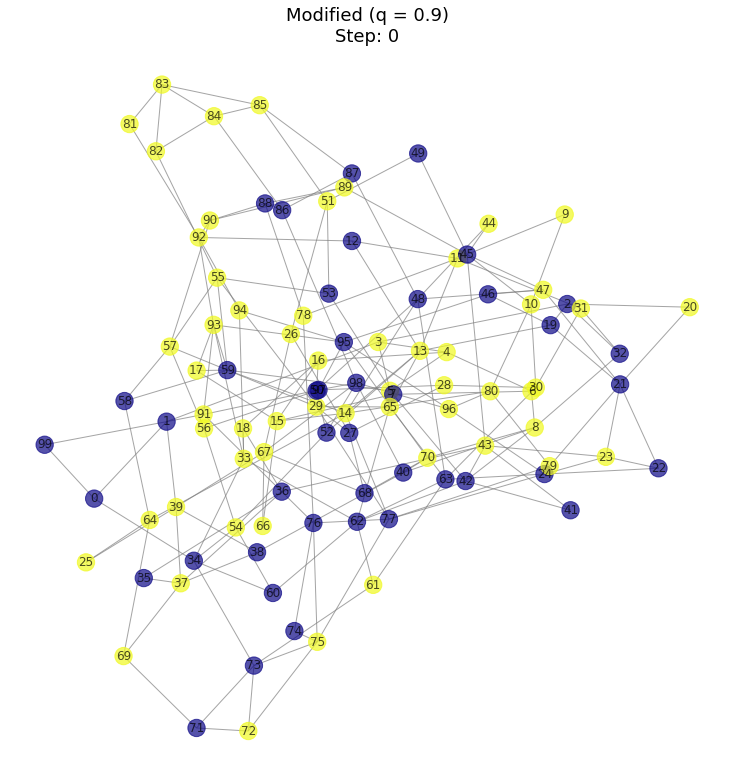

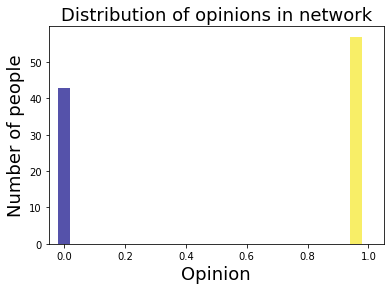

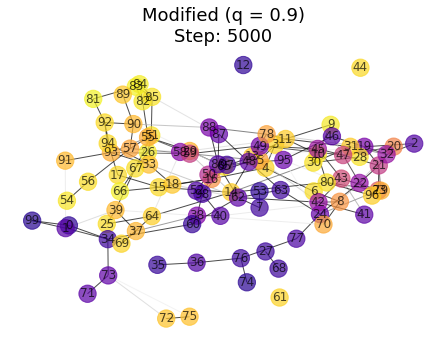

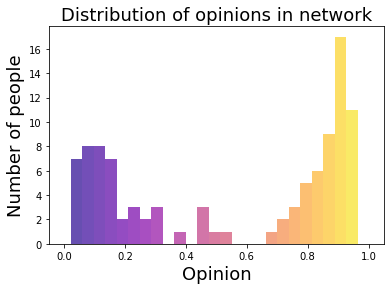

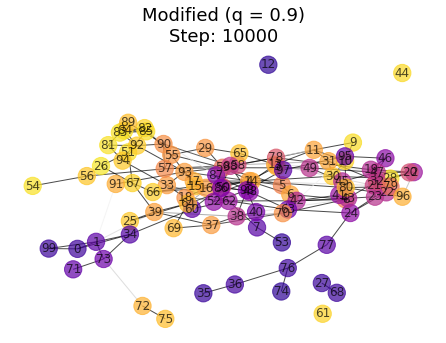

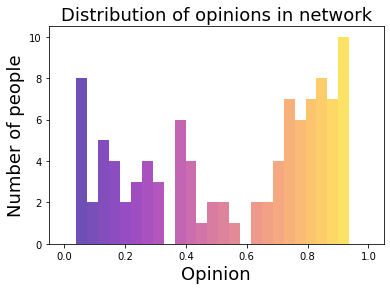

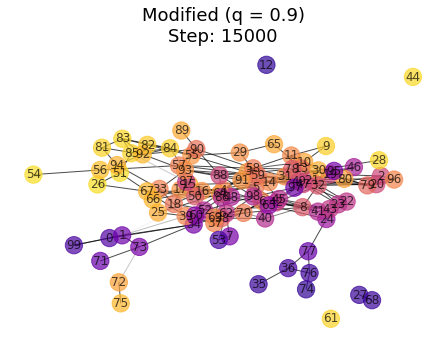

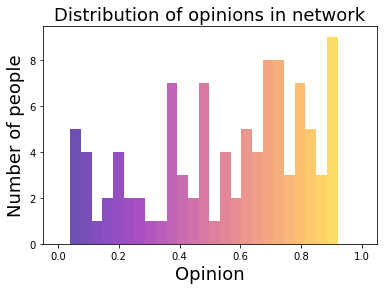

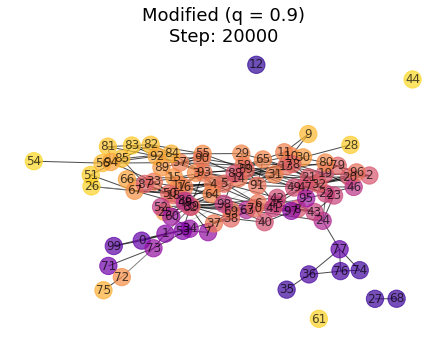

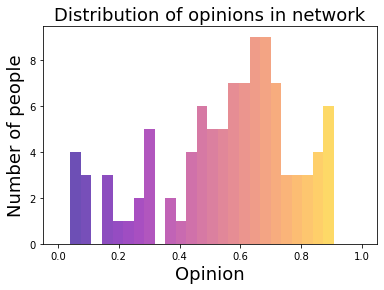

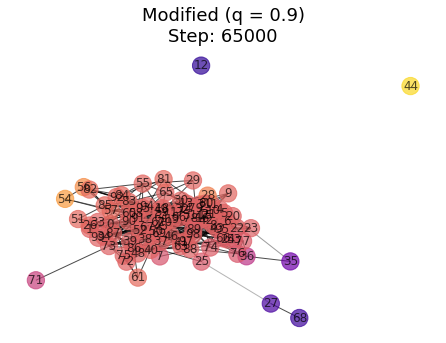

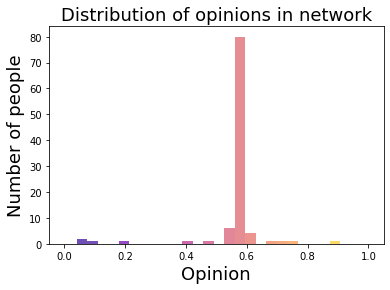

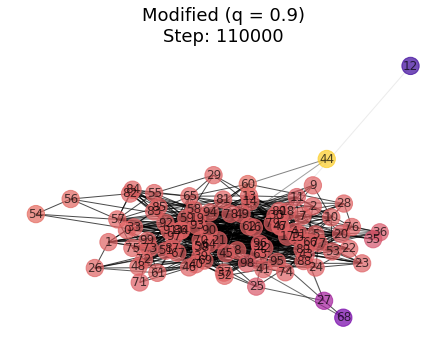

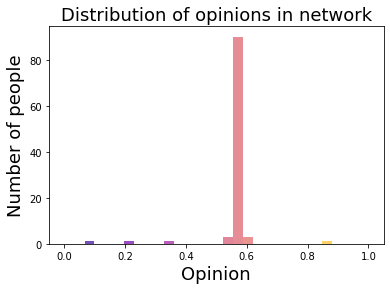

In [11]:
modified = NewSimulation()
modified.initialize()

#plotting initial state to make sure everything's equal
plt.figure(figsize=(10,10))
modified.observe()
plt.show()

data_m = [modified.graph.nodes[n]['opinion'] for n in modified.graph.nodes]
plot_hist(data_m)
plt.show()


#simulate update steps and show result for every 6000 steps
for i in range(6):
    for j in range(5000):
        modified.update()
        
    if i>3:#in the last 2 iterations end do 40000 extra steps to see the long-run results
        for i in range(40000):
            modified.update()

    modified.observe()
    plt.show()
    data_m = [modified.graph.nodes[n]['opinion'] for n in modified.graph.nodes]

    plot_hist(data_m)
    plt.show()
